## https://www.setlist.fm/search?query=scorpions

In [32]:
from robobrowser import RoboBrowser
import geocoder
import folium
import pandas as pd
import dateparser
from joblib import Memory
import difflib
import pycountry
from iso3166 import countries
memory = Memory(cachedir='tmp', verbose=0)

In [33]:
url = 'https://www.setlist.fm/search?query=scorpions'
browser = RoboBrowser(history=True, parser='html5lib')
browser.open(url)
concert = browser.select('.setlistPreview')[0]
concert

<div class="col-xs-12 setlistPreview">
<div>
<div class="condensed dateBlock">
<span class="month">Nov</span>
<span class="day">3</span>
<span class="year">2017</span>

</div>
</div>
<div>
<h2><a href="setlist/scorpions/2017/ledovy-dvorets-saint-petersburg-russia-63e362eb.html" title="View this Scorpions setlist">Scorpions at Ledovy Dvorets, Saint-Petersburg, Russia</a></h2>
<div class="details">
<span>Artist: <strong><a href="setlists/scorpions-3d63ddf.html" title="More Scorpions setlists"><span>Scorpions</span></a></strong></span>,

<span>
Tour:
<strong><a href="search?artist=3d63ddf&amp;query=tour:%28Crazy+World+2017+Tour%29" rel="nofollow" title='Search Scorpions setlists by tour: "Crazy World 2017 Tour"'>Crazy World 2017 Tour</a></strong>
</span>,

<span>Venue: <strong><a href="venue/ledovy-dvorets-saint-petersburg-russia-13d7cdb1.html" title="More setlists from Ledovy Dvorets, Saint-Petersburg, Russia"><span>Ledovy Dvorets, Saint-Petersburg, Russia</span></a></strong></span>
</di

In [34]:
day = concert.select('.day')[0].text
month = concert.select('.month')[0].text
year = concert.select('.year')[0].text
desc = concert.select('h2 a')[0].text
print(day,month,year,desc)

3 Nov 2017 Scorpions at Ledovy Dvorets, Saint-Petersburg, Russia


In [35]:
idx = desc.find(' at ')+4
loc = desc[idx:]
loc_pieces = loc.split(',')
if len(loc_pieces)>=3:
    loc = ','.join(loc_pieces[-3:])
print(loc)

Ledovy Dvorets, Saint-Petersburg, Russia


In [36]:
g=geocoder.google(loc)
print(g.geojson)


{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'properties': {'accuracy': 'ROOFTOP', 'address': 'просп. Пятилеток, 1, Sankt-Peterburg, Russia, 193318', 'bbox': [30.4669800197085, 59.9202687197085, 30.4696779802915, 59.92296668029151], 'city': 'СПБ', 'confidence': 9, 'country': 'RU', 'county': 'Sankt-Peterburg', 'housenumber': '1', 'lat': 59.92161770000001, 'lng': 30.468329, 'ok': True, 'place': 'ChIJW86eTBIulkYRjwvvpZ2MEVg', 'postal': '193318', 'quality': 'establishment', 'raw': {'address_components': [{'long_name': '1', 'short_name': '1', 'types': ['street_number']}, {'long_name': 'просп. Пятилеток', 'short_name': 'просп. Пятилеток', 'types': ['route']}, {'long_name': 'Sankt-Peterburg', 'short_name': 'СПБ', 'types': ['locality', 'political']}, {'long_name': 'Sankt-Peterburg', 'short_name': 'Sankt-Peterburg', 'types': ['administrative_area_level_2', 'political']}, {'long_name': 'Russia', 'short_name': 'RU', 'types': ['country', 'political']}, {'long_name': '193318', 'sh

In [37]:
import pprint
pprint.pprint(g.geojson)

{'features': [{'bbox': [30.4669800197085,
                        59.9202687197085,
                        30.4696779802915,
                        59.92296668029151],
               'geometry': {'coordinates': [30.468329, 59.92161770000001],
                            'type': 'Point'},
               'properties': {'accuracy': 'ROOFTOP',
                              'address': 'просп. Пятилеток, 1, '
                                         'Sankt-Peterburg, Russia, 193318',
                              'bbox': [30.4669800197085,
                                       59.9202687197085,
                                       30.4696779802915,
                                       59.92296668029151],
                              'city': 'СПБ',
                              'confidence': 9,
                              'country': 'RU',
                              'county': 'Sankt-Peterburg',
                              'housenumber': '1',
                              'lat': 

In [38]:
code=g.geojson['features'][0]['properties']['country']
print(code)

RU


In [39]:
from iso3166 import countries
code=countries.get(code).alpha3
print(code)

RUS


In [40]:
@memory.cache
def get_latlng(query):
    try:
        g=geocoder.google(query)
        if g:
            country = g.geojson['features'][0]['properties']['country']
            code=countries.get(country).alpha3
            print(query, g.latlng, code)
            return g.latlng+[code]
        else:
            return None, None, None
    except:
        return None, None, None
    

@memory.cache
def get_data_paged(query, page):
    url = 'https://www.setlist.fm/search?page={}&query={}'.format(page, query)
    browser.open(url.format(page))
    data = []
    for concert in browser.select('.setlistPreview'):
        month = concert.select('.month')[0].text
        day = concert.select('.day')[0].text
        year = concert.select('.year')[0].text
        datetext = "{}, {} {}".format(year, month, day)
        date = dateparser.parse(datetext)
        desc = concert.select('h2 a')[0].text
        idx = desc.find(' at ')+4
        loc = desc[idx:]
        loc_pieces = loc.split(',')
        #print(loc_pieces[-1],country)
        if loc == None:
            continue
        if len(loc_pieces)>=3:
            loc = ','.join(loc_pieces[-3:])
        lat, lng, code = get_latlng(loc)
        if lat and lng:
            data.append([loc, lat, lng, code, date, desc])
    return data
    
columns = ['loc', 'lat', 'lon', 'code', 'date', 'desc']
concerts = pd.DataFrame(columns = columns)
for page in range(1,15):
    data = get_data_paged('Scorpions', page)
    df = pd.DataFrame(data, columns = columns)
    concerts = concerts.append(df)

concerts.head(20)

,loc,lat,lon,code,date,desc
0,"Olympijskiy Stadium, Moscow, Russia",55.781050,37.626457,RUS,2017-11-01,"Scorpions at Olympijskiy Stadium, Moscow, Russia"
1,"SK ""Basket Hall"", Krasnodar, Russia",45.117544,38.981297,RUS,2017-10-30,"Scorpions at SK ""Basket Hall"", Krasnodar, Russia"
2,"Ledovaya Arena 'Shayba', Sochi, Russia",43.402260,39.951905,RUS,2017-10-28,"Scorpions at Ledovaya Arena 'Shayba', Sochi, R..."
3,"Inglewood, CA, USA",33.961680,-118.353131,USA,2017-10-07,"Scorpions at The Forum, Inglewood, CA, USA"
4,"Oakland, CA, USA",37.804364,-122.271114,USA,2017-10-04,"Scorpions at Oracle Arena, Oakland, CA, USA"
5,"Reno, NV, USA",39.529633,-119.813803,USA,2017-10-03,"Scorpions at Grand Sierra Theatre, Reno, NV, USA"
6,"Tacoma, WA, USA",47.252877,-122.444291,USA,2017-09-30,"Scorpions at Tacoma Dome, Tacoma, WA, USA"
7,"Spokane, WA, USA",47.658780,-117.426046,USA,2017-09-29,"Scorpions at Spokane Arena, Spokane, WA, USA"
8,"West Valley, UT, USA",40.691613,-112.001050,USA,2017-09-26,"Scorpions at USANA Amphitheatre, West Valley, ..."
0,"Rosemont, IL, USA",41.986751,-87.872160,USA,2017-09-23,"Scorpions at Allstate Arena, Rosemont, IL, USA"


In [41]:
import plotly.plotly as py

great_lines = [ 
        dict(
            type = 'scattergeo',
            lon = concerts['lon'],
            lat = concerts['lat'],
            mode = 'lines',
            line = dict(
                    width = 1,
                    color = 'rgba(255,0,0,0.5)',
                    ),
        )
        ]
venue_markers = [ dict(
        type = 'scattergeo',
        lon = concerts['lon'],
        lat = concerts['lat'],
        hoverinfo = 'loc',
        text = concerts['loc'],
        mode = 'markers',
        marker = dict( 
            size=10, 
            color='rgba(255,0,0,0.5)',   
        ))]
    
layout = dict(
        title = 'recitales',
        width = 1000,
        height = 800,
            showlegend = False, 

            showland = True,
            showcountries = True,
            showocean = True,
            countrywidth = 0.5,
            landcolor = '#fff',
            oceancolor = '#eee',
    
        geo = dict(
            projection = dict( 
                type = 'Mercator',          
            ),
            
        )
    )
    
fig = dict( data=great_lines+venue_markers, layout=layout )
py.iplot( fig, validate=False, filename='d3-globe' )

In [42]:
df = concerts.groupby('code').count()
df.head(20)

,loc,lat,lon,date,desc
code,,,,,
ARE,1,1,1,1,1
ARG,1,1,1,1,1
AUS,1,1,1,1,1
BEL,3,3,3,3,3
BGR,1,1,1,1,1
BRA,5,5,5,5,5
CAN,6,6,6,6,6
CHE,3,3,3,3,3
CHL,1,1,1,1,1


In [43]:
df=df.reset_index()
df.head(20)

,code,loc,lat,lon,date,desc
0,ARE,1,1,1,1,1
1,ARG,1,1,1,1,1
2,AUS,1,1,1,1,1
3,BEL,3,3,3,3,3
4,BGR,1,1,1,1,1
5,BRA,5,5,5,5,5
6,CAN,6,6,6,6,6
7,CHE,3,3,3,3,3
8,CHL,1,1,1,1,1
9,CHN,1,1,1,1,1


In [44]:
data = [ dict(
        type = 'choropleth',
        locations = df['code'],
        z = df['loc'],
        autocolorscale = True,
        marker = dict(
            line = dict (
                color = 'rgb(180,180,180)',
                width = 0.5
            ) ),
        colorbar = dict(
            autotick = False,
            tickprefix = '',
            title = 'concerts'),
      ) ]

markers = [ dict(
        type = 'scattergeo',
        lon = concerts['lon'],
        lat = concerts['lat'],
        hovertext  = concerts['loc'],
        text = concerts['loc'] ,
        textposition = 'top center',
        mode = 'markers',
        string = concerts['loc'],
        marker = dict( 
            symbol = ['4'],
            size=10, 
            color='black',  
            linecolor = 'white'
            
        ))]

layout = dict(
    width = 800,
    height = 800,
    showlegend = False, 
    title = 'concerts scorpions',
    geo = dict(
        showframe = True,
        showcoastlines = True,
        projection = dict( 
                type = 'orthographic',
                rotation = dict(
                    lon = -100,
                    lat = 40,
                    roll = 0
                )            
            ),
    )
)

fig = dict( data=data+markers+great_lines, layout=layout )
py.iplot( fig, validate=False, filename='d3-world-map' )

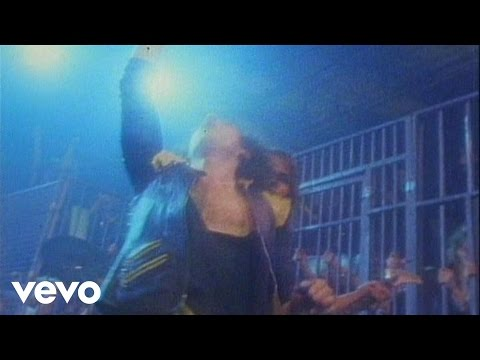

In [45]:
from datetime import timedelta
from IPython.display import YouTubeVideo
start=int(timedelta(hours=0, minutes=1, seconds=54).total_seconds())
YouTubeVideo("6yP1tcy9a10", start=start, autoplay=1, theme="light", color="red")